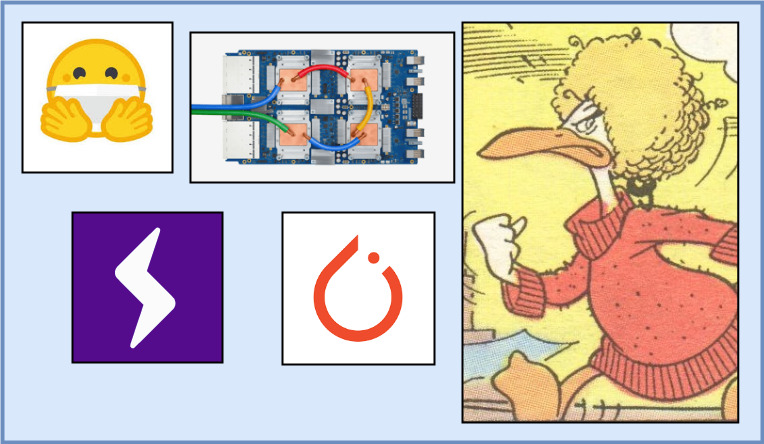

# Table of content

This will be a (very) long notebook so feel free to skip to any part you like using this table of content: 

- [Introduction](#intro)
- [Before you start: NLP with Transformers](#before-you-start)
 * [Transformers 101](#transformers-101)
 * [BERT and the NLP revolution](#bert)
- [What is RoBERTa anyway?](#roberta)
- [How does it work?](#how)
- [How to train?](#train)
 * [A small detour: Pytorch Lightning](#detour)
 * [Tokens](#tokens)
- [Application: Tweet Sentiment Extraction](#application)
 * [Understanding the task](#understanding)
 * [Evaluation metric](#loss)
 * [Data processing](#processing)
 * [The model](#model)
 * [Training](#training)
- [Going beyond](#going-beyond)

<a id="intro"></a>
# Introduction 

Hello all! 

I am new<sup>[1](#new)</sup> to both [NLP](https://en.wikipedia.org/wiki/Natural_language_processing) tasks (in its transformers variation at least) and [TPU](https://fr.wikipedia.org/wiki/Tensor_Processing_Unit) training, so this is the best way for me to learn both in the same time (galaxy-brain smartness). 

More specifically, this notebook will focus on understanding and applying the [RoBERTa](https://huggingface.co/transformers/model_doc/roberta.html) model to the current challenge.

To start, I will quickly describe and explain how the model works. Then I will build and train a model using the competition's dataset.

Before starting, notice that some parts of the applied section here are inspired from this great [notebook](https://www.kaggle.com/abhishek/roberta-on-steroids-pytorch-tpu-training) by [Abhishek Thakur](https://www.kaggle.com/abhishek), so give it an upvote at least if you have enjoyed his work. Also, a lot of my understanding comes from reading a lot of discussions shared by [Chris Deotte](https://www.kaggle.com/cdeotte), so thanks again!


As a teaser, here is a timeline<sup>[2](#transformer-logo)</sup> of what we will explore in the next sections: 


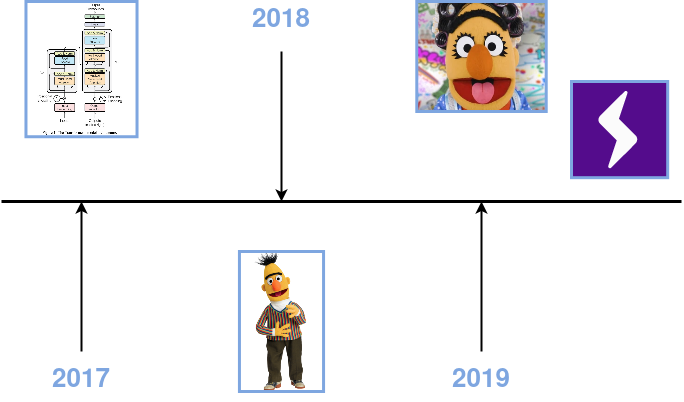

Finally<sup>[3](#ad)</sup>, check this long discussion if you want to learn more about [TPUs](https://www.kaggle.com/c/tweet-sentiment-extraction/discussion/146266). 

Let's go!



<a name="new">1</a>: Well I used to be new but now, thanks to writing this notebook and reading hundreds of disucssions, blog posts, and notebooks, I am a little bit wiser. The road ahead is still long but I have made some progress. :)

<a name="transformer-logo">2</a>: The transformer-architecture-as-a-logo is blurry, might need to do it again later.


<a name="ad">3</a>: A minor self-promotion here. The discussion got some upvotes so it must be interesting. ;)



<a id="before-you-start"></a>
# Before you start: NLP with Transformers

For those familiar with NLP and "modern" techniques using transformers, you can skip this section entirely. 
For all the others, time to learn something new! 




<a id="transformers-101"></a>

## Transformers 101

I will try to be precise and concise. As far as I know, NLP applications started gaining momentum once the [transformer](https://en.wikipedia.or/wiki/Transformer_(machine_learning_model)) paper was released (around end of 2017). 


In its essence, a **transformer** model is a seq2seq self-supervised task that only uses self-attention. Voilà, easy. ;)

Let's unpack this for a second: 


- [seq2seq](https://en.wikipedia.org/wiki/Seq2seq): this means that the model uses more than one sample to produce more than one output
- [self-supervised](https://project.inria.fr/paiss/files/2018/07/zisserman-self-supervised.pdf): this is in contrast to supervised learning, i.e. no labels are needed, only training data. 
- [self-attention](https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/): a technique used in seq2seq models to better incorporate the context by leveraging many of the hidden states (and not the last one).  

In more details, it is a stack of encoders and decoders where inputs flow through encoders, outputs flow through decoders and intermediate representations are shared between the decoder and encoder (check the graph below):

<img src="http://jalammar.github.io/images/t/transformer_resideual_layer_norm_3.png" width=480>

Since the inputs and outputs are textual, there is a need for an embedding layer: a layer that takes as input words and returns number mappings (i.e. one word 
gets mapped to a unique number). 



Here is an implementation of an encoder/decoder architecture (from the [annotated](http://nlp.seas.harvard.edu/2018/04/03/attention.html) paper):

``` python 
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many 
    other models.
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        return self.decode(self.encode(src, src_mask), src_mask,
                            tgt, tgt_mask)
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)
```

Each encoder and decoder blocks are made of two essential elements: a self-attention block and a feed-forward one (check the graph below). The decoder block has one additional self-attention block for the signal it receives from the encoder. There are many other details I am omitting, so check the resources for more details. Here is how the diagram looks like: 

<img src="https://miro.medium.com/max/1400/1*BHzGVskWGS_3jEcYYi6miQ.png" width=480>


One final detail, notice that the original transformer paper had **6** of these stacked. Many variations on the original transformer will make slight changes to one single block and also on how many blocks are stacked and how they are connected (and other details). I will stop here before loosing too much audience. 


If you haven't checked the famous [illustrated transformer](http://jalammar.github.io/illustrated-transformer/) blog post, go read it now. From there, you will come across two other great resources: the original [paper](https://arxiv.org/pdf/1706.03762.pdf) and an [annotated](http://nlp.seas.harvard.edu/2018/04/03/attention.html) version (with code). You can also add this [medium](https://medium.com/inside-machine-learning/what-is-a-transformer-d07dd1fbec04) post to your transformers reading list. Finally, if you prefer videos, check this one (next cell): 

In [ ]:
from IPython.display import YouTubeVideo

YouTubeVideo('iDulhoQ2pro', width=480)

Alright, enough with transformers. Time to get to BERT!

<a id="bert"></a>
## BERT and the NLP revolution

Once the transformer model came out, a lot of innovation happened. And among the most important (or at least a precursor for other things) for the NLP world was [BERT](https://en.wikipedia.org/wiki/BERT_(language_model)). 


<img src="https://vignette.wikia.nocookie.net/muppet/images/e/e1/Bert_smile.png/revision/latest/scale-to-width-down/280?cb=20110630173259" width=200>


Well, not the [Sesame Street](https://en.wikipedia.org/wiki/Sesame_Street) [character](https://muppet.fandom.com/wiki/Bert) of course. :) 


What is **BERT** then? 


It is short for **Bidirectional Encoder Representations from Transformers**. This is a pre-training self-supervised language model 
based on the transformers building block. It has been developed by Google around 2018 (last quarter of 2018). 

As the name suggests, since this is a language model (i.e. nothing to predict, only learning a language representation), only the encoder part from the transformer's architecture is necessary.

One of the main innovations compared to previous models that also use the transformer as a building block ([ELMo](https://allennlp.org/elmo) and [GPT-1](https://openai.com/blog/language-unsupervised/) for example) is the **bidirectionality** of the connections (check graph below): 


<img src="https://miro.medium.com/max/1234/1*KbAUVetHPMreJdcbicmJrw.png" alt="bert_vs_gpt_vs_elmo" width=720>


To be more precise, BERT could be described as being non-directional since each input sequence is fed at once. But that wouldn't
make a good Sesame Street name, would it? ;)


Now you might ask how is the model trained if there isn't any privileged direction (thus can't predict next-word for example)? There are two things to know: 


- **MLM** (Masked Language Model): the first idea is to train a language model by masking some of the tokens and asking the model to predict these masked tokens (only the masked ones). For this task, the model uses a mask embedding (check the next graph)
- **NSP** (Next Sentence Prediction): the second idea is to concatenate two sentences in two different ways, either using two consecutive sentences (in most cases there is a casual connection between the two) or one sentence followed by a randomly selected one. Then letting the model learn how to distinguish between the two scenarios. For this, the model uses a sequence embedding (check the next graph).

These two powerful ideas are combined when training a BERT model. That's not the whole story of course and many more 
details are missing. To wrap up, here is how the embedding layers look like: 

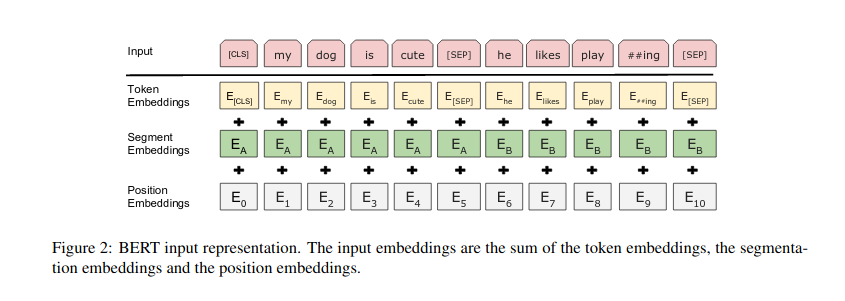


and some tips from the transformers' [documentation](https://huggingface.co/transformers/model_doc/bert.html): 



- BERT is a model with absolute position embeddings so it’s usually advised to pad the inputs on the right rather than the left.

- BERT was trained with a masked language modeling (MLM) objective. It is therefore efficient at predicting masked tokens and at NLU in general, but is not optimal for text generation. Models trained with a causal language modeling (CLM) objective are better in that regard.

- Alongside MLM, BERT was trained using a next sentence prediction (NSP) objective using the [CLS] token as a sequence approximate. The user may use this token (the first token in a sequence built with special tokens) to get a sequence prediction rather than a token prediction. However, averaging over the sequence may yield better results than using the [CLS] token.





That's it for BERT. The ideas aren't necessarily very complex to understand in isolation but understanding everything and making the different connections might take some time. So don't feel bad if you don't understand everything at first. Read more later and revist the concepts you have learned. 

You can find the paper [here](https://arxiv.org/pdf/1810.04805.pdf). I also recommend checking the transformers documentation [page](https://huggingface.co/transformers/model_doc/bert.html) and this medium blog [post](https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270). Finally, if you prefer watching videos, check this one (next cell): 


In [ ]:
from IPython.display import YouTubeVideo

YouTubeVideo('-9evrZnBorM', width=480)

<a id="roberta"></a>
# What is RoBERTa anyway?

Alright, enough with BERT. Let's move to RoBERTa. Could it be BERT's mom (as suggested by [Maximilien Roberti](https://www.kaggle.com/maroberti))?


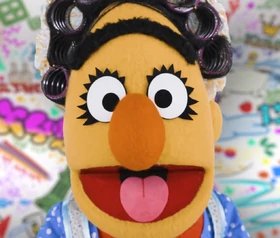

Alright, joke aside, RoBERTa is an NLP model that introduces slight variations on the BERT model (more about these below) and achieves better results. 

It has been proposed by researchers (list in the screenshot below) from [FAIR](https://ai.facebook.com/) around 2019. Since then, the model has been used in many settings and in particular at Kaggle to win competitions: [here](https://www.kaggle.com/c/google-quest-challenge/discussion/129978) and [here](https://www.kaggle.com/c/tensorflow2-question-answering/discussion/127339). 

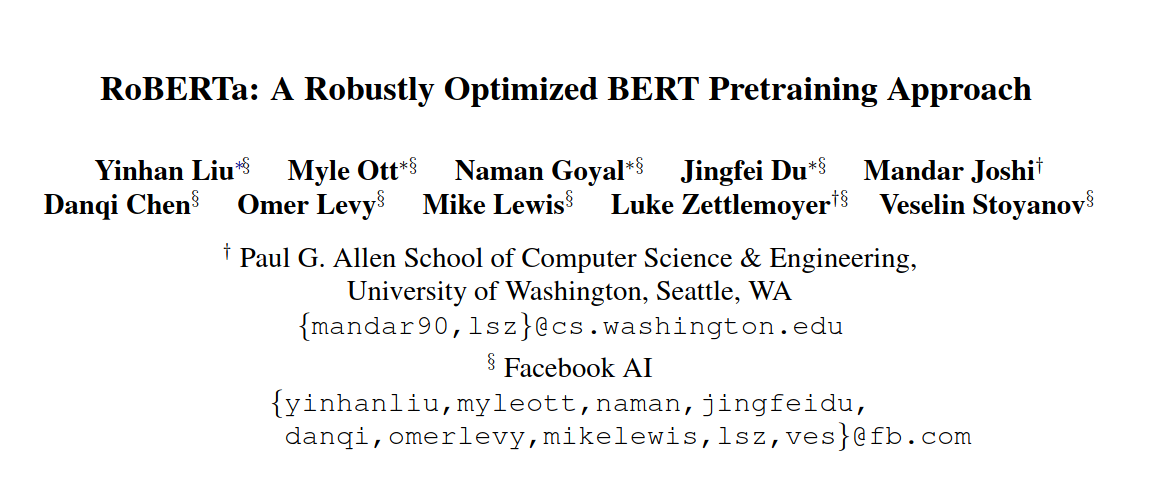

From the [FAIR](https://ai.facebook.com/blog/roberta-an-optimized-method-for-pretraining-self-supervised-nlp-systems/) team's blog post:

> A robustly optimized method for pretraining natural language processing (NLP) systems that improves on Bidirectional Encoder Representations from Transformers, or BERT, the self-supervised method released by Google in 2018. BERT is a revolutionary technique that achieved state-of-the-art results on a range of NLP tasks while relying on unannotated text drawn from the web, as opposed to a language corpus that’s been labeled specifically for a given task. The technique has since become popular both as an NLP research baseline and as a final task architecture. BERT also highlights the collaborative nature of AI research — thanks to Google’s open release, we were able to conduct a replication study of BERT, revealing opportunities to improve its performance. Our optimized method, RoBERTa, produces state-of-the-art results on the widely used NLP benchmark, General Language Understanding Evaluation (GLUE).

<a id="how"></a>
# How does it work?

From the FAIR blog post again: 
    
    
> RoBERTa builds on BERT’s language masking strategy, wherein the system learns to predict intentionally hidden sections of text within otherwise unannotated language examples. RoBERTa, which was implemented in PyTorch, modifies key hyperparameters in BERT, including removing BERT’s next-sentence pretraining objective, and training with much larger mini-batches and learning rates. This allows RoBERTa to improve on the masked language modeling objective compared with BERT and leads to better downstream task performance. We also explore training RoBERTa on an order of magnitude more data than BERT, for a longer amount of time. We used existing unannotated NLP data sets as well as CC-News, a novel set drawn from public news articles.

> After implementing these design changes, our model delivered state-of-the-art performance on the MNLI, QNLI, RTE, STS-B, and RACE tasks and a sizable performance improvement on the GLUE benchmark. With a score of 88.5, RoBERTa reached the top position on the GLUE leaderboard, matching the performance of the previous leader, XLNet-Large. These results highlight the importance of previously unexplored design choices in BERT training and help disentangle the relative contributions of data size, training time, and pretraining objectives.


Here are the main changes made to the BERT model to make it better:
    
    
>Our modifications are simple, they include: (1)training the model longer, with bigger batches,over more data; (2) removing the next sentence prediction objective; (3) training on longer sequences; and (4) dynamically changing the masking pattern applied to the training data


As mentioned in the transformers [documentation](https://huggingface.co/transformers/model_doc/roberta.html), here are some of the tips summarized:
    
* This implementation is the same as BertModel with a tiny embeddings tweak as well as a setup for Roberta pretrained models.

* RoBERTa has the same architecture as BERT, but uses a byte-level BPE as a tokenizer (same as GPT-2) and uses a different pre-training scheme.

* RoBERTa doesn’t have token_type_ids, you don’t need to indicate which token belongs to which segment. Just separate your segments with the separation token tokenizer.sep_token (or `</s>`)


So, the **TL;DR** of RoBERTa vs BERT are the following: 


1. Use of different tokenizers: byte-level BPE vs WordPiece 
2. Different pre-training procedures: no NSP for RoBERTa
3. Longer training with larger batches on more data
4. Dynamically changing the masking strategy

There are many more details that we won't explore here. For more details, check the original [paper](https://arxiv.org/pdf/1907.11692.pdf). Also, if you like videos, check this out (a visual analysis of the paper on the next cell): 

In [ ]:
from IPython.display import YouTubeVideo

YouTubeVideo('-MCYbmU9kfg', width=480)

Time is short, so let's train a model!

<a id="train"></a>
# How to train?

We are almost there. Before we start training, in the context of this notebook, training here means using RoBERTa as a backbone and then adding some
additional layers to make the generic backbone work well for the task at hand. 

For that, we need the following things: 
     
- The model: RoBERTa backbone + other layers.
- How to get the [tokens](https://en.wikipedia.org/wiki/Lexical_analysis#Tokenization): transforming textual information into numbers.
- Training: loading data, setting the model, backpropagation, optimizer, and so on. The usual stuff really.


<a id="detour"></a>
## A small detour: [PytorchLightning](https://github.com/PyTorchLightning/pytorch-lightning)


Before we start, you can skip this part entierly if you are in a hurry. 


Few weeks ago, I organized a twitter poll (see what I did there, twitterception) to check which library I should use: 

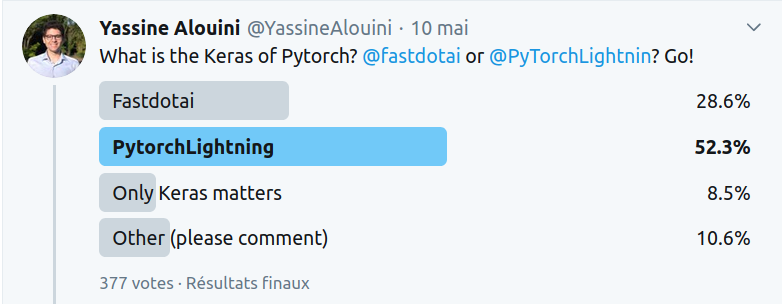



The winner was [**PytorchLightning**](https://github.com/PyTorchLightning/pytorch-lightning) so I decided to train the model using it. If you are more familiar with Pytorch, here is a [video](https://www.youtube.com/watch?v=QHww1JH7IDU) explaining how to move from one to the other. 


Alright! In PytorchLightning, there are two main concepts: 


1. LightningModule
2. Trainer


First thing, we define a simple model that inherits from the `LightningModule` class:  


``` python 

import torch
from torch.nn import functional as F
from torch import nn
from pytorch_lightning.core.lightning import LightningModule
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import os
from torchvision import datasets, transforms
from torchvision.datasets import MNIST
from torch.optim import Adam
from pytorch_lightning import Trainer, seed_everything




class LitMNIST(LightningModule):
    def __init__(self):
        super().__init__()
        self.layer_1 = torch.nn.Linear(28 * 28, 128)
        self.layer_2 = torch.nn.Linear(128, 256)
        self.layer_3 = torch.nn.Linear(256, 10)

    def forward(self, x):
        batch_size, _, _, _ = x.size()
        x = x.view(batch_size, -1)
        x = self.layer_1(x)
        x = torch.relu(x)
        x = self.layer_2(x)
        x = torch.relu(x)
        x = self.layer_3(x)
        x = torch.log_softmax(x, dim=1)
        return x

    def prepare_data(self):
        # download only
        MNIST(os.getcwd(), train=True, download=True)

    def train_dataloader(self):
        transform=transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,))])
        mnist_train = MNIST(os.getcwd(), train=True, download=False, transform=transform)
        return DataLoader(mnist_train, batch_size=64)


    def configure_optimizers(self):
        return Adam(self.parameters(), lr=1e-3)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)

        # add logging
        logs = {'loss': loss}
        return {'loss': loss, 'log': logs}

```


This model can be run similarly to any Pytorch model: 


``` python 
net = LitMNIST()
x = torch.Tensor(1, 1, 28, 28)
out = net(x)
print(out)
# tensor([[-2.2469, -2.2845, -2.3024, -2.3162, -2.2317, -2.3438, -2.2973, -2.3393,
#          -2.3107, -2.3608]], grad_fn=<LogSoftmaxBackward>)


```

The different thing is that in addition to the model per say (`forward` and `__init__` methods mainly), we have here 
the **data processing**, **optimizer**, and the **training loop** within the LitMNIST class. These steps contain less boilerplate as well.

Next concept, is the `[Trainer](https://pytorch-lightning.readthedocs.io/en/latest/trainer.html)`: 


``` python 
model = LitMNIST()
trainer = Trainer(gpus=1, max_epochs=5, deterministic=True)
trainer.fit(model)
```

As you can see, here we have specified that the trainer should run using one GPU. We will see later that
it is as easy (modulo some small changes) to use TPUs and that's what we will do. Before moving to the next section, notice that there are other alternatives to PytorchLightning (if you don't like the syntax for example): Pytorch of course and many more. Among these, you can use [fastai v2](https://github.com/fastai/fastai2) library. Maybe I will explore this in a later notebook. ;)

<a id="tokens"></a>
## Tokens

Now that the model is defined, we can move to the extraction of tokens. 

But first, what are tokens? From [Wikipedia](https://en.wikipedia.org/wiki/Lexical_analysis#Tokenization): 


> Tokenization is the process of demarcating and possibly classifying sections of a string of input characters.

Tokens are not necessarily words and aren't always obtained by splitting on space but are rather entities that make parsing the text possible. For more details about tokens, check this [link](https://nlp.stanford.edu/IR-book/html/htmledition/tokenization-1.html). 


Now, how to get these? Well, as many things in the ML world, there is a library for that: introducing [tokenizers](https://github.com/huggingface/tokenizers). 

You can also access tokenizer classes directly from the transformers library. Here are some details from the [documentation](https://huggingface.co/transformers/main_classes/tokenizer.html): 


> A tokenizer is in charge of preparing the inputs for a model. The library comprise tokenizers for all the models. Most of the tokenizers are available in two flavors: a full python implementation and a “Fast” implementation based on the Rust library tokenizers. The “Fast” implementations allows (1) a significant speed-up in particular when doing batched tokenization and (2) additional methods to map between the original string (character and words) and the token space (e.g. getting the index of the token comprising a given character or the span of characters corresponding to a given token). Currently no “Fast” implementation is available for the SentencePiece-based tokenizers (for T5, ALBERT, CamemBERT, XLMRoBERTa and XLNet models).


As you have seen above, RoBERTa uses a different tokenizer than the one used by BERT: byte-level BPE vs WordPiece. Here are the main differences between the two: 

* RoBERTa's default tokenizer works at the byte-level vs word pieces for BERT.
* RoBERTa's tokenizer keeps all combined tokens (up to the vocabulary max size) whereas BERT's only keeps those that increase

For more details, check this StackOverflow [thread](https://stackoverflow.com/questions/55382596/how-is-wordpiece-tokenization-helpful-to-effectively-deal-with-rare-words-proble) and this medium blog [post](https://towardsdatascience.com/comparing-transformer-tokenizers-686307856955) with comparaison of different tokenizers. Finally, if you want to learn more about BPE implementation, check this [blog](https://towardsdatascience.com/byte-pair-encoding-the-dark-horse-of-modern-nlp-eb36c7df4f10). 



Next, to get the tokenizer for RoBERTa, it is as simple as the following using the `tokenizers` library: 


``` python 

from tokenizers import ByteLevelBPETokenizer


tokenizer = ByteLevelBPETokenizer(vocab_file="path/to/vocab.json", 
                                  merges_file="path/to/merges.txt", 
                                  add_prefix_space=True)

tokenizer.encode("A sentence to encode")

```


or directly using the `transformers` library

``` python 

from transformers import RobertaTokenizerFast

tokenizer = RobertaTokenizerFast(vocab_file="path/to/vocab.json", 
                                 merges_file="path/to/merges.txt", 
                                 add_prefix_space=True)

tokenizer.encode("A sentence to encode")

```

Few more things to know about the RoBERTa's tokenizer:


- The first 4 token ids are the following (special tokens): `{"<s>": 0, "<pad>": 1, "</s>": 2, "<unk>": 3}`
- RoBERTa's default vocabulary size is **50262** (compare this to BERT's uncased 30522)
- You can use the classmethod `from_pretrained` to get the default vocab and merges files from the internet (well this
is a generic fact for all transformers's tokenizers).


<a id="application"></a>
# Application: Tweet Sentiment Extraction

Alright, enough with the theory, time to apply what we have learned so far to this competition's dataset. 

<a id="understanding"></a>
## Understanding the task

First thing to do is to understand what we need to predict and the data at hand. 
Here we are given some tweets (this is from a popular dataset), associated sentiments (positive, negative, or neutral), and 
the **text that helps extract the sentiment**. 

For example: 

```

text = Sooo SAD I will miss you here in San Diego!!!

sentiment = negative 

selected_text = Sooo SAD


```

The task is thus to extract a sub-part of a given sentence that captures the sentiment.

In [ ]:
import pandas as pd


train_df = pd.read_csv("../input/tweet-sentiment-extraction/train.csv")
train_df.sample(5)

In [ ]:
train_df.loc[3, ["text", "selected_text", "sentiment"]]

In the example above, notice that the "negativity" (probably a sentiment of anger or disgust) can be understood from the expression "leave me alone". 

<a id="loss"></a>
## Evaluation metric

As stated in the evaluation page:
    
> The metric in this competition is the word-level Jaccard score 

Here is a link to the Wikipedia [page](https://en.wikipedia.org/wiki/Jaccard_index). 

Kaggle has also provided a Python implementation: 

``` python 
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

```


As far as I know, this metric is also popular in computer vision object detection tasks. Let's have a look at one simple example: 

In [ ]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    print(a)
    print(b)
    print(c)
    return float(len(c)) / (len(a) + len(b) - len(c))

s_1 = "This is a sentence."
s_2 = "This is another sentence."

print(jaccard(s_1,s_2))



s_1 = "sentence. this is"
s_2 = "is this sentence."

print(jaccard(s_1,s_2))


s_1 = "This is a Sentence."
s_2 = "THIS IS a sentenCE."

print(jaccard(s_1,s_2))



Few remarks about this metric: 
    
* the computation happens at the word level: a word is extracted for each new space. 
* the order of words doesn't matter (second example)
* upper and lower case words (even when mixed cases) are similar (third example)
* the evaluation metric is the mean over all the entries
* the provided implementation isn't robust when both strings are empty

<a id="model"></a>
## The model

As stated before, we will be using PytorchLighning alongside the [transformers](https://huggingface.co/transformers/) (awesome) library from [huggingface](https://huggingface.co/). 

Here is what we need: 


- A pretrained RoBERTa base
- Adding a "head" (i.e. some new layers) for the task



Let's go!

In [ ]:
# We need to install pytorch lightning. Notice that we can use pip directly here since this is 
# the training notebook. When working with the inference, you need to load it from a dataset though.
!pip install pytorch_lightning

In [ ]:
# Pytorch Lightning, Pytorch, transformers, and tokenizers imports
from pytorch_lightning.core.lightning import LightningModule
from pytorch_lightning import Trainer, seed_everything

from torch import nn
import torch
from torch.optim import AdamW
from torch.utils.data import Dataset
from torch.utils.data.distributed import DistributedSampler
from torch.utils.data.dataloader import DataLoader


from transformers import RobertaModel, RobertaConfig
from tokenizers import ByteLevelBPETokenizer

import numpy as np


# Some constants
LEARNING_RATE = 0.2 * 3e-5
MAX_LEN = 192
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 8
EPOCHS = 3
ROBERTA_PATH = "../input/roberta-base/"

# Create the RoBERTa tokenizer. Notice that we are using the one from 
# tokenizers and passing a local file. These would be much easier to do if there was 
# a from_pretrained method and if the transformers RoBERTa tokenizer could return 
roberta_tokenizer = ByteLevelBPETokenizer(
    vocab_file=f"{ROBERTA_PATH}/vocab.json", 
    merges_file=f"{ROBERTA_PATH}/merges.txt", 
    lowercase=True, # TODO: Does keeping uppercase help?
    add_prefix_space=True # Otherwise, will have an extra space at the start of a sequence.
)

# Create the RoBERTa config
roberta_config = RobertaConfig.from_pretrained("roberta-base", output_hidden_states=True)

In [ ]:
# Let's check the config
roberta_config

From this config, we can deduce few things: 
    
    
- `bos_token_id` is 0
- `eos_token_id` is 2
- `vocab_size` is 50265, i.e. how many different token ids.
- `hidden_size` is 768

What type of fine-tuning should we do here? As stated in the previous section, the first thing to do
is understand the task and look for something similar in previously fine-tuned tasks: in research papers, previous
Kaggle competitions, i.e. don't be a hero and invent your own (or do it if you have enough experience). 

Based on other notebooks, it seems that `selected_text` can be treated as an answer and the `text` as a question. 
So we can get inspiration from a Q&A task. 


In [ ]:
class LightningTwitterModel(LightningModule):
    
    def __init__(self):
        super().__init__()
        self.config = roberta_config
        self.roberta = RobertaModel.from_pretrained("roberta-base", config=self.config)
        # You can also try other rates or even different regularization layers
        self.dropout = nn.Dropout(0.1)
        # Start and end positions
        self.num_targets = 2
        # 2 here is for the use of two hidden layers
        self.classifier = nn.Linear(self.config.hidden_size * 2, self.num_targets)
        torch.nn.init.normal_(self.classifier.weight, std=0.02)
        
    
    def forward(self, ids, attention_mask):
        # We get the hidden layers (12 here) as the third output
        _, _, hidden_layers = self.roberta(
            ids,
            attention_mask=attention_mask
        )
        # Other things that you can explore: use more that just the two last hidden layers.
        x = torch.cat((hidden_layers[-1], hidden_layers[-2]), dim=-1)
        x = self.dropout(x)
        logits = self.classifier(x)

        # Some processing to get two outputs (start and end) in the correct format
        start_logits, end_logits = logits.split(1, dim=-1)

        start_logits = start_logits.squeeze(-1)
        end_logits = end_logits.squeeze(-1)

        return start_logits, end_logits
    

In [ ]:
model = LightningTwitterModel()

Now that the model is defined, one trick is to check that it works by passing one input sample. This serves as a sanity check: have you correctly named the layers that you call in the `forwad` method, is your input what you think it is and so on. 

In [ ]:
# We pass pytorch tensors to check that the model works. Notice the use of unsqueeze to 
# get the batch dimension correct.
output = model(torch.tensor([0, 1313, 2, 2, 42, 16, 41, 6344, 3545, 328, 2], dtype=torch.long).unsqueeze(0), 
      torch.tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=torch.long).unsqueeze(0), 
)

start_pos_logit = output[0]
end_pos_logit = output[1]
print(start_pos_logit)
print(end_pos_logit)

<a id="processing"></a>
## Data processing

Alright, now that we have a model, we need to feed it some data. For that, we will need to: 
    
    
- Preprocess the data
- Tokenize the dataset

Once these steps done, we will be able to add the `train_dataloader`, `val_dataloader`, and `test_dataloader` methods. 


Before we start, we can do some preliminary work: 
    
    
``` python 
sentiment_id = {
    'positive': 1313,
    'negative': 2430,
    'neutral': 7974
}

```

You may ask, where does these values come from? And why do we need them in the first place?


1. You get these ids by running the RoBERTa tokenizer on the three types of sentiments: 


``` python 

for sentiment in ["negative", "positive", "neutral"]:
    print(roberta_tokenizer.encode(sentiment).id)

```

2. So instead of re-running the same computation over and over again for each row, we store these into a dict (a cheap cache). 
We need these values to correctly tokenize the `text` + `extracted_text`. More about this soon.

In [ ]:
# Here is the computation for the sentiment ids
for sentiment in ["positive", "negative", "neutral"]:
    print(roberta_tokenizer.encode(sentiment).ids[0])

Another handy thing to know, is how does the RoBERTa tokenizer handle concatenated sequences? 
To answer this, we can use the `encode_plus` function. 
Credit for this tip goes to Chris Deotte: 
    
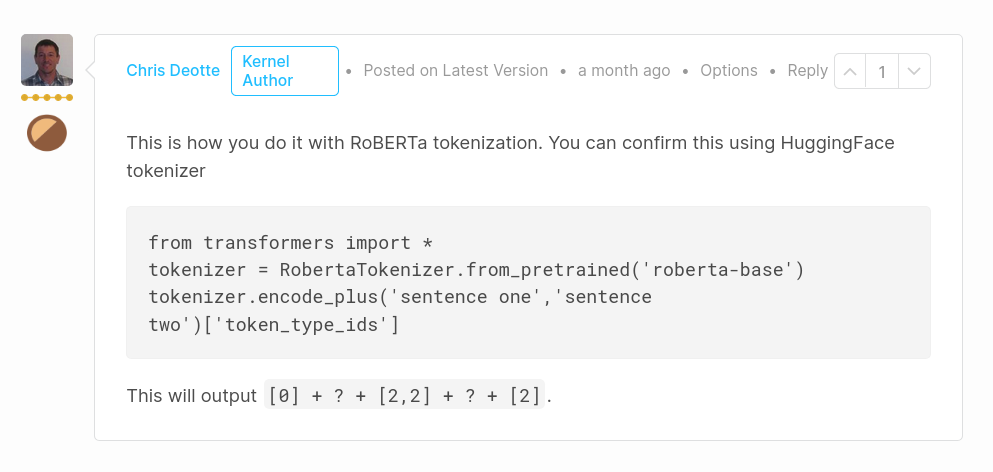

In [ ]:
# Here it is in action 
from transformers import RobertaTokenizerFast


another_roberta_tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")
another_roberta_tokenizer.encode_plus("This is sentence one", "This is sentence two")

So as you can see, the first token id is 0, the end of the first sentence is 2, the start of the seconde sentence is 2,
and the last token is 2. Alright, time to write the processing function<sup>[4](#processing)</sup>.

<a name="processing">4</a>: Most of the processing function is from [Abhishek Thakur](https://www.kaggle.com/abhishek) great kernel so again, thanks to him!

In [ ]:
def process_data(tweet, selected_text, sentiment, tokenizer, max_len):
    
    # We add a space in front for the Roberata tokenizer. Same thing fot the selected text. 
    # As turns out, doing this processing step could be improved. Check the many top solutions 
    # for better approaches.
    tweet = " " + " ".join(str(tweet).split())
    selected_text = " " + " ".join(str(selected_text).split())

    len_st = len(selected_text) - 1
    idx0 = None
    idx1 = None

    # Find the start and end 
    for ind in (i for i, e in enumerate(tweet) if e == selected_text[1]):
        if " " + tweet[ind: ind+len_st] == selected_text:
            idx0 = ind
            idx1 = ind + len_st - 1
            break

    char_targets = [0] * len(tweet)
    if idx0 != None and idx1 != None:
        for ct in range(idx0, idx1 + 1):
            char_targets[ct] = 1

    # Tokenize the tweet text and get ids and offsets
    # One detail here: we need to use the tokenizer from the tokenizers
    # library since the one from transformers doesn't provide offsets
    # (or maybe I am wrong, please correct me in the comments if that is the case).
    tokenzed_tweet = tokenizer.encode(tweet)
    input_ids_orig = tokenzed_tweet.ids
    tweet_offsets = tokenzed_tweet.offsets
    
    
    target_idx = []
    for j, (offset1, offset2) in enumerate(tweet_offsets):
        if sum(char_targets[offset1: offset2]) > 0:
            target_idx.append(j)
    
    targets_start = target_idx[0]
    targets_end = target_idx[-1]

    sentiment_id = {
        'positive': 1313,
        'negative': 2430,
        'neutral': 7974
    }
    # 0 seems to be the starting token. 2 is the ending one. Between the two, we add the sentiment.
    input_ids = [0] + [sentiment_id[sentiment]] + [2] + [2] + input_ids_orig + [2]
    # The mask is as long as the input_ids
    mask = [1] * (len(input_ids))
    tweet_offsets = [(0, 0)] * 4 + tweet_offsets + [(0, 0)]
    # We add 4 since there are always 4 tokens preceeding the target.
    targets_start += 4
    targets_end += 4

    
    # How much to pad the text to have the same sequence lengths. 
    padding_length = max_len - len(input_ids)
    if padding_length > 0:
        input_ids = input_ids + ([1] * padding_length)
        mask = mask + ([0] * padding_length)
        tweet_offsets = tweet_offsets + ([(0, 0)] * padding_length)
    
    return {
        # Tokenized input
        'ids': input_ids,
        'attention_mask': mask,
        'targets_start': targets_start,
        'targets_end': targets_end,
        'offsets': tweet_offsets, 
        # Original input
        'tweet': tweet,
        'selected_text': selected_text,
        'sentiment': sentiment
    }

Let's unpack this whole `process_data` function: 


* Start by finding the positions of start and end words in from the `selected_text` within the `text`
* Tokenizing the tweet `text` and extracting ids and offsets
* Adding 0, sentiment_token_id, 2, 2 to the token_ids and four (0,0) at the start of the offsets and one (0, 0) at the end.
* Adding 4 to the start and end target tokens. This is done since there are always 4 tokens before: 0, sentiment_token_id, 2, 2.
* Finally, we pad the tokenized input, the mask, and the offsets to match the `max_len`: each sequence has its special padding token.



Next, we will run it on different inputs and check the outputs.

In [ ]:
max_len = 14
processed_sample = process_data("This is a very AWESOME tweet!", "very AWESOME", "positive", roberta_tokenizer, max_len)
token_ids = processed_sample["ids"]
attention_mask = processed_sample["attention_mask"]


assert len(token_ids) == max_len
assert len(attention_mask) == max_len

print(token_ids)
print(attention_mask)
print(processed_sample["targets_start"])
print(processed_sample["targets_end"])
print(processed_sample["offsets"])

Few more things to notice: 
    
    
- As you can see, the second token id is the sentiment
- Token ids are padded with 1s whereas mask ids are padded with 0s
- The offsets are the start and end of each word. They are paddeds with 0s
- The padded token ids and mask ids have the length of `max_len`

Let's try a different example by varying few things

In [ ]:
max_len = 20
processed_sample = process_data("This is an AWESOME tweet!!!!", "AWESOME", "negative", roberta_tokenizer, 20)
token_ids = processed_sample["ids"]

assert len(token_ids) == max_len
print(token_ids)
print(processed_sample["offsets"])

Alright, time to add the different [`DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)s. <sup>[5](#dataloader)</sup>.

For that, we will need:

- A Dataset: this is the way Pytorch understands the data. There are a lot of details [here](https://pytorch.org/docs/stable/data.html) (about dataset styles and so), so  check them if you are curious.
- A Sampler: this is the way Pytorch samples from the provided. 


Once we have these, we can make a DataLoader: one for training, and one for validation. If you want have more folds, you will have a pair of (train, val) DataLoaders for each fold. For the sake of simplicity, we will only make a train/validation split here. 




<a name="dataloader">5</a>: This usual business for Pytorch, nothing specific to PytorchLightning.

In what follows, I introduce the `TweetDataset`. This variation comes from this [notebook](https://www.kaggle.com/shoheiazuma/tweet-sentiment-roberta-pytorch), so thanks [sazuma](https://www.kaggle.com/shoheiazuma) for this work as well. For the sake of readability and modularity, the `process_data` function has been 
split into two methods: 

- `get_input_data`: given a row from a DataFrame, returns the following values: ids, masks, tweet, offsets
- `get_target_idx`: returns the start and end indices given a row, a tweet text, and offsets

These two methods are then called to make the data dict in the `__getitem__` method. That's it.

In [ ]:
class TweetDataset(Dataset):
    def __init__(self, df, max_len=96):
        self.df = df
        self.max_len = max_len
        self.labeled = 'selected_text' in df
        self.tokenizer = roberta_tokenizer

    def __getitem__(self, index):
        data = {}
        row = self.df.iloc[index]
        
        ids, masks, tweet, offsets = self.get_input_data(row)
        data['ids'] = ids
        data['masks'] = masks
        data['tweet'] = tweet
        data['offsets'] = offsets
        
        if self.labeled:
            start_idx, end_idx = self.get_target_idx(row, tweet, offsets)
            data['start_idx'] = start_idx
            data['end_idx'] = end_idx
        
        return data

    def __len__(self):
        return len(self.df)
    
    def get_input_data(self, row):
        tweet = " " + " ".join(row.text.lower().split())
        encoding = self.tokenizer.encode(tweet)
        sentiment_id = self.tokenizer.encode(row.sentiment).ids
        ids = [0] + sentiment_id + [2, 2] + encoding.ids + [2]
        offsets = [(0, 0)] * 4 + encoding.offsets + [(0, 0)]
                
        pad_len = self.max_len - len(ids)
        if pad_len > 0:
            ids += [1] * pad_len
            offsets += [(0, 0)] * pad_len
        
        ids = torch.tensor(ids)
        masks = torch.where(ids != 1, torch.tensor(1), torch.tensor(0))
        offsets = torch.tensor(offsets)
        
        return ids, masks, tweet, offsets
        
    def get_target_idx(self, row, tweet, offsets):
        selected_text = " " +  " ".join(row.selected_text.lower().split())

        len_st = len(selected_text) - 1
        idx0 = None
        idx1 = None

        for ind in (i for i, e in enumerate(tweet) if e == selected_text[1]):
            if " " + tweet[ind: ind+len_st] == selected_text:
                idx0 = ind
                idx1 = ind + len_st - 1
                break

        char_targets = [0] * len(tweet)
        if idx0 != None and idx1 != None:
            for ct in range(idx0, idx1 + 1):
                char_targets[ct] = 1

        target_idx = []
        for j, (offset1, offset2) in enumerate(offsets):
            if sum(char_targets[offset1: offset2]) > 0:
                target_idx.append(j)

        start_idx = target_idx[0]
        end_idx = target_idx[-1]
        
        return start_idx, end_idx

And with the `Dataset` defined, we can get the train and validation DataLoaders. I will use 20/80% split for the sake of 
simplicity (but you should experiment with better options). 

In [ ]:
def get_train_val_loaders(df, train_idx, val_idx, batch_size=8):
    train_df = df.iloc[train_idx]
    val_df = df.iloc[val_idx]

    train_loader = DataLoader(
        TweetDataset(train_df), 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=2,
        drop_last=True)

    val_loader = DataLoader(
        TweetDataset(val_df), 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=2)

    return train_loader, val_loader

In [ ]:
# Here, I am using a very basic 20/80% split schema. Better schema should be used of course
# for example stratified kfold over the sentiment column + averaging over many seeds for stability.
train_idx_end = int(len(train_df) * 0.8)
train_idx = train_df.index[:train_idx_end]
val_idx = train_df.index[train_idx_end:]

train_loader, val_loader = get_train_val_loaders(train_df, train_idx, val_idx)

In [ ]:
len(train_loader)

In [ ]:
len(val_loader)

Now, we need to add two new methods to our `LightningTwitterModel` class: 
    
- train_dataloader: this should return the training dataloader
- val_dataloader: same thing but for the validation

In [ ]:
def train_dataloader(self):
    return train_loader

def val_dataloader(self):
    return val_loader



LightningTwitterModel.train_dataloader = train_dataloader
LightningTwitterModel.val_dataloader = val_dataloader


Sweet! Time to train!

<a id="training"></a>
## Training 

Alright, we are almost there. Time to train the model that we have defined above. Few things to add: 
    
- a loss function: we will go with binary cross entropy for each indix (start and end) and sum these. 
- an evaluation function: this is useful to see how our model performs on the validation dataset. We will be using 
the competition's metric: Jaccard.
- an optimizer: this defines the gradient descent algorithm. Will be using AdamW. 


Another thing to keep in mind is seeding your model before running it. For that, Pytorch Lightning provide a `seed_everything` function (should be familiar to those used to running Kaggle kernels ;)). To learn more about this, check the Pytorch official [documentation](https://pytorch.org/docs/stable/notes/randomness.html).

In [ ]:
# The loss function 
def compute_loss(start_logits, end_logits, start_positions, end_positions):
    # Sum of BCE for start and end logits. 
    loss_fct = nn.CrossEntropyLoss()
    start_loss = loss_fct(start_logits, start_positions)
    end_loss = loss_fct(end_logits, end_positions)
    total_loss = (start_loss + end_loss)
    return total_loss

In [ ]:
# The evaluation function + some utiliy functions
def get_selected_text(text, start_idx, end_idx, offsets):
    selected_text = ""
    for ix in range(start_idx, end_idx + 1):
        selected_text += text[offsets[ix][0]: offsets[ix][1]]
        if (ix + 1) < len(offsets) and offsets[ix][1] < offsets[ix + 1][0]:
            selected_text += " "
    return selected_text

def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))


# This function works with batches of inputs
def compute_jaccard_score(text, start_idx, end_idx, start_logits, end_logits, offsets):

    # Some processing so that the output of the model can be used here
    start_idx = start_idx.cpu().detach().numpy()
    end_idx = end_idx.cpu().detach().numpy()
    start_logits = torch.softmax(start_logits, dim=1).cpu().detach().numpy()
    end_logits = torch.softmax(end_logits, dim=1).cpu().detach().numpy()


    
    # TODO: Make this vectorized
    # Since we have a batch of each input, we need to iterate over these
    # We will take the average of the scores across batches
    score = 0
    for i in range(len(text)):
        start_pred = np.argmax(start_logits[i])
        end_pred = np.argmax(end_logits[i])
        if start_pred > end_pred:
            pred = text[i]
        else:
            pred = get_selected_text(text[i], start_pred, end_pred, offsets[i])

        true = get_selected_text(text[i], start_idx[i], end_idx[i], offsets[i])
    
        score += jaccard(true, pred)
    
    return score / len(text)


And as before, we will add new methods to our `LightningTwitterModel` class: 
    
- `configure_optimizers`: this is how the optimizer should be set up. Nothing fancy here, just the regular stuff.
- `training_step`: given a batch of data, how to get the targets and then compute the loss
- `validation_step`: given a batch of data, how to get the targets and then compute the loss and score
- `validation_end`: how to aggregate the different validation scores at the end of one epoch?

In [ ]:
def training_step(self, batch, batch_nb):
    input_ids = batch['ids']
    attention_masks = batch['masks']
    tweet = batch['tweet']
    offsets = batch['offsets']
    start_positions = batch['start_idx']
    end_positions = batch['end_idx']

    
    start_logits, end_logits = self(input_ids, attention_masks)


    loss = compute_loss(start_logits, end_logits, start_positions, end_positions)

    logs = {'train_loss': loss}
    return {'loss': loss, 'log': logs}


def validation_step(self, batch, batch_nb):
    input_ids = batch['ids']
    attention_masks = batch['masks']
    tweet = batch['tweet']
    offsets = batch['offsets']
    start_positions = batch['start_idx']
    end_positions = batch['end_idx']  

    start_logits, end_logits = self(input_ids, attention_masks)


    loss = compute_loss(start_logits, end_logits, start_positions, end_positions)

    score = compute_jaccard_score(tweet, start_positions, end_positions, start_logits, end_logits, offsets)
    return {'val_loss': loss, 'val_score': score}

def validation_epoch_end(self, outputs):

    return {'val_loss': torch.mean(torch.tensor([output['val_loss'] for output in outputs])).detach(), 
            'val_score': torch.mean(torch.tensor([output['val_score'] for output in outputs])).detach()}


def configure_optimizers(self):
    param_optimizer = list(self.named_parameters())
    no_decay = [
        "bias",
        "LayerNorm.bias",
        "LayerNorm.weight"
    ]
    optimizer_parameters = [
        {
            'params': [
                p for n, p in param_optimizer if not any(
                    nd in n for nd in no_decay
                )
            ],
            'weight_decay': 0.001
        },
        {
            'params': [
                p for n, p in param_optimizer if any(
                    nd in n for nd in no_decay
                )
            ],
            'weight_decay': 0.0
        },
    ]
    return AdamW(
        optimizer_parameters,
        lr=LEARNING_RATE
    )


LightningTwitterModel.training_step = training_step
LightningTwitterModel.validation_step = validation_step
LightningTwitterModel.validation_epoch_end = validation_epoch_end
LightningTwitterModel.configure_optimizers = configure_optimizers

Final step: training. That's the best part in Pytorch Lightning: 
    
- you create an instance of your `model`
- you setup a `Trainer` instance with the type of the accelerator
- you `.fit` your `model`

That's it, really. Since this is a demo notebook, I will also pass the `fast_dev_run=True` option 
in the Trainer to only run for one step and get the results faster. 

In [ ]:
seed_everything(42)
model = LightningTwitterModel()
# Remove the fast_dev_run when running "for real":) 
trainer = Trainer(gpus=1, max_epochs=3, deterministic=True, fast_dev_run=True)
# Notice that instead of defining the training and validation dataloaders in the model class, you can pass
# them to the fit method.
trainer.fit(model)

We also get integration with `tensoarboard` but it doesn't seem to work [here](https://www.kaggle.com/aagundez/using-tensorboard-in-kaggle-kernels). Any tips are welcome in the comments!

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir lightning_logs/

What about training on TPUs? 

Well, you just need to change the trainer: 
    
`tpu_trainer = Trainer(num_tpu_cores=8, progress_bar_refresh_rate=5, max_epochs=3)`

You also need to install the `pytorch-xla` library: this is how Pytorch can communicate with TPUs.

``` bash
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --apt-packages libomp5 libopenblas-dev
!export XLA_USE_BF16=1
```

Finally, to make it run here on the Kaggle notebook, you will need to change the Accelerator to **TPU v3-8** (on the right panel, in the Settings) and re-run the cells. If you need more details, let me know in the comments!

This is only the training part. For inference, you can check this [notebook](https://www.kaggle.com/yassinealouini/model-inference-only). You only need to save the model as a dataset and load it. 
One more thing to notice is that the inference part uses GPU and not TPU since it wasn't allowed. Some people have reported some discrepancy between training on TPU vs training on GPU then predicting on GPU. If you know why, please share your insights in the comments below.

<a id="going-beyond"></a>
# Going beyond

That's it for now. Congratulations for getting to the end!

This has been a very long notebook and I hope you got something out of it. To be honest, the primary intended reader is myself and I have learned a ton from writing it over the past few weeks. As some parting (cheap) wisdom: the best way to learn something is to teach yourself how to do it.

For further exploration, check the following resources: 

* Another BERT variation, this time from Google: [Albert](https://arxiv.org/pdf/1909.11942.pdf)
* Nothing to do with NLP, but this was handy: how to create a [table of content](https://www.kaggle.com/dcstang/create-table-of-contents-in-a-notebook#Making-a-Table-of-Contents) in Kaggle
* Good RoBERTa explanation + TF implementation [details](https://www.kaggle.com/c/tweet-sentiment-extraction/discussion/143281)
* NLP's Imagenet moment blog [post](https://thegradient.pub/nlp-imagenet/)
* Encoder-Decoder in transformers [explained](https://medium.com/huggingface/encoder-decoders-in-transformers-a-hybrid-pre-trained-architecture-for-seq2seq-af4d7bf14bb8)
* Another great RoBERTa notebook, this time using Tensorflow by [Chris Deotte](https://www.kaggle.com/cdeotte): https://www.kaggle.com/cdeotte/tensorflow-roberta-0-705. The tokenization part is well explained there with a nice graph. Same thing for a model representation. 
* For those that want to get better using fastai, here is a nice [notebook](https://www.kaggle.com/maroberti/fastai-with-transformers-bert-roberta)
* Another fastai + transformers medium blog [post](https://towardsdatascience.com/fastai-with-transformers-bert-roberta-xlnet-xlm-distilbert-4f41ee18ecb2)
* Same as above but this time as a [notebook](https://www.kaggle.com/maroberti/fastai-with-transformers-bert-roberta)
* A blog post comparing different [tokenizers](https://towardsdatascience.com/comparing-transformer-tokenizers-686307856955)
* The videos in this notebook are from https://twitter.com/ykilcher so thanks to him as well!
* Good blog post on why Pytorch Lightning might be [worth it](https://towardsdatascience.com/supercharge-your-ai-research-with-pytorch-lightning-337948a99eec)

See you next time. 